# Collaborative filtering methods

<b>Collaborative filtering</b> is recommendation strategy which uses the information about users' ratings historical data. Based on that information it calculates similarity between users or items and recommend the most similar. 

I will focus on approaches:

1. <b>Memory-based</b> :
    * <b>User-based</b> - measures the similarity between target users and other users.
    * <b>Item-based</b> - measures the similarity between the items that target users rate and other items.
 
 
2. <b>Matrix factorization</b> - decomposing the ratings matrix into the product of two lower dimensionality rectangular matrices. One matrix can be seen as the user matrix where rows represent users and columns are latent factors. The other matrix is the item matrix where rows are latent factors and columns represent items.[3]

In this project the recommendation engine will the Surprise library in Python.


## Import libraries

In [159]:
import pandas as pd
import random
import dexplot
from surprise import Reader, Dataset
from surprise.model_selection import GridSearchCV, cross_validate
from surprise.prediction_algorithms import KNNBasic,KNNBaseline,KNNWithZScore,KNNWithMeans,NormalPredictor, SVD, SVDpp
from surprise import accuracy
from eda import show_df_info, show_duplicates, choose_values, grouping, check_ratings
from recommend import get_top_n, get_names
import matplotlib.pyplot as plt
from model_graf import plot_diff

## Data

1. <b>Ratings</b> - contain information how users rated specific books.

    Columns:
    * user_id
    * book_id
    * rating


2. <b>Books</b> - contain some information about books. In this notebook only few columns will be used.

    Columns:
    * book_id
    * title
    * authors

In [2]:
ratings = pd.read_csv(filepath_or_buffer='./goodbooks-10k-1.0/ratings.csv')
books = pd.read_csv(filepath_or_buffer='./goodbooks-10k-1.0/books.csv', usecols=['book_id','title','authors'])

## Exploatory Data Analysis

Let's check how data looks like, if there are any NaN values or duplicated rows.

In [3]:
show_df_info(ratings)

Header : 


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


Number of rows : 5976479
Number of NaN values in each column : 


user_id    0
book_id    0
rating     0
dtype: int64

In [4]:
show_duplicates(ratings[['user_id','book_id']])

Number of duplicated rows : 


0

In [5]:
show_df_info(books)

Header : 


,book_id,authors,title
0,1,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)"
1,2,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...
2,3,Stephenie Meyer,"Twilight (Twilight, #1)"
3,4,Harper Lee,To Kill a Mockingbird
4,5,F. Scott Fitzgerald,The Great Gatsby


Number of rows : 10000
Number of NaN values in each column : 


book_id    0
authors    0
title      0
dtype: int64

Information about well-known book 'Harry Potter and the Sorcerer's Stone' is shown above. It is obvious that the author of this books is J.K. Rowling. Mary GrandPré is an illustrator. Only information about the author is needed in order to identify the book. In this case I will leave only one person name in the author column. Even if a book has more than one author it still will be easy to find if we knew one author + title.

In [6]:
books.authors = books.authors.str.partition(',')[0]

In [7]:
show_duplicates(books)

Number of duplicated rows : 


0

There is almost a 6 million ratings - it would be hard to process such amount of data. I have to reduce the number of observations. I will randomly choose around 5% of users. The new ratings dataframe will contain only rates given by these users.
There is 10000 different books. I will limite they amount by choosing only half of them with the highest number of ratings.

In [8]:
random.seed(5)

In [9]:
n = 0.05
ratings = choose_values(n, ratings, 'user_id')

In [10]:
print(f'Current number of rows in ratings dataframe is {len(ratings)}.')

Current number of rows in ratings dataframe is 299308.


In [18]:
grouped_by_book = grouping(ratings,'book_id').sort_values()

In [22]:
ratings = ratings[ratings.book_id.isin(grouped_by_book[5000:].index)]

In [24]:
print(f'Current number of rows in ratings dataframe is {len(ratings)}.')

Current number of rows in ratings dataframe is 261232.


Let's see the distribution of number of ratings per book:

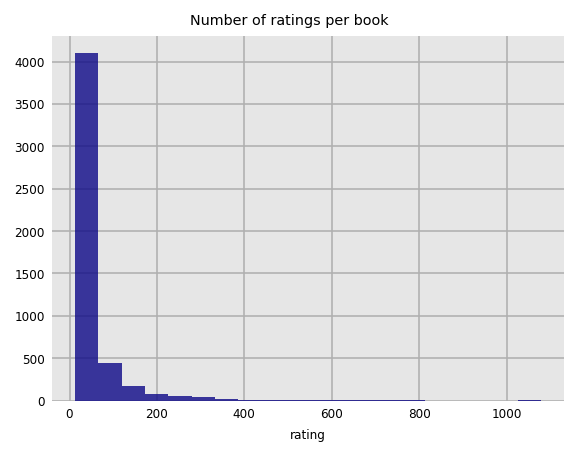

Statistics for dataframe grouped by book_id:
count    4987.000000
mean       52.382595
std        83.432535
min        13.000000
25%        17.000000
50%        26.000000
75%        49.000000
max      1079.000000
Name: rating, dtype: float64


In [28]:
check_ratings(ratings, 'book_id')

Let's see the distribution of number of books ratings per user:

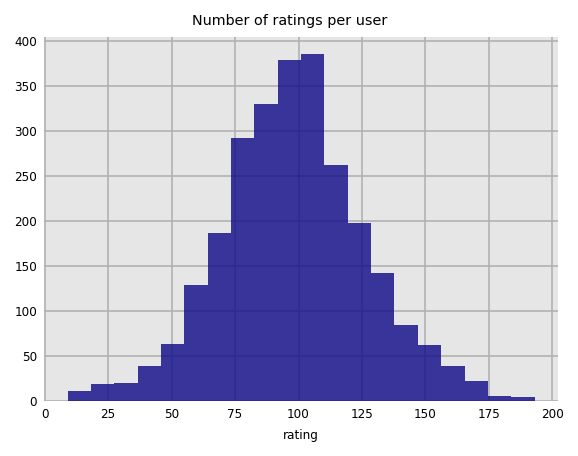

Statistics for dataframe grouped by user_id:
count    2671.000000
mean       97.803070
std        28.093466
min         9.000000
25%        80.000000
50%        98.000000
75%       115.000000
max       193.000000
Name: rating, dtype: float64


In [29]:
check_ratings(ratings, 'user_id')

Statistics for ratings :

In [30]:
ratings.rating.describe()

count    261232.000000
mean          3.909866
std           0.990667
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

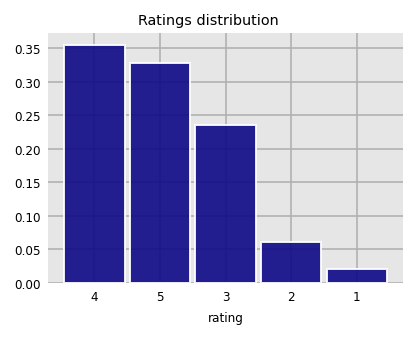

In [31]:
dexplot.count(val='rating', data=ratings, normalize= True, title='Ratings distribution', cmap='plasma')

## Prediction models
In this section I will construct models with different approaches and compare them:
1. Random
2. Collaborative filtering :
   * User based
   * Item based
3. Matrix factorization

At first the reader and data has to be defined.

In [32]:
reader = Reader(rating_scale=(1, 5))
#Load ratings as dataset
data = Dataset.load_from_df(ratings, reader)
raw_ratings = data.raw_ratings
random.shuffle(raw_ratings)

In [33]:
train_size = int(0.8 * len(raw_ratings)) 
train_raw_ratings = raw_ratings[:train_size]
test_raw_ratings = raw_ratings[train_size:]
# data is now trainset
data.raw_ratings = train_raw_ratings

Let's create an empty list which will store the information about used models.

In [194]:
models_info = []

Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.

In [40]:
model = NormalPredictor()
models_info.append(('Random', model))

User-based/ Item-based collaborative filtering

In [195]:
def grid_knn(model_dict, k=[40], min_k=[1], cv=5, similarities_list=['pearson'], user_based=[True]):
    results_list = []
    #Define param grid
    param_grid = dict()
    param_grid['k'] = k
    param_grid['min_k'] = min_k
    param_grid['sim_options'] = dict()
    param_grid['sim_options']['name'] = similarities_list
    param_grid['sim_options']['user_based'] = user_based
    for name, model in model_dict.items():
        grid = GridSearchCV(model,param_grid, cv=cv, n_jobs=-1)
        grid.fit(data)
        print(f' Best parameters for model {name} are {grid.best_params}')
        results_list.append((name, grid))
    return results_list

In [196]:
#model_dict = {'KNNBasic': KNNBasic,'KNNBaseline': KNNBaseline,
#              'KNNWithZScore': KNNWithZScore, 'KNNWithMeans' :KNNWithMeans}
knn_model_dict = {'KNNBasic': KNNBasic, 'KNNBaseline' : KNNBaseline}
k_list = [10, 20, 30]
min_k_list = [1, 5, 10]
similarities_list = ['cosine', 'pearson']


In [197]:
for user_based in [[False]]:
    result = grid_knn(knn_model_dict, k = k_list, min_k = min_k_list, similarities_list=similarities_list, user_based=user_based)
    models_info += result

 Best parameters for model KNNBasic are {'rmse': {'k': 30, 'min_k': 1, 'sim_options': {'name': 'cosine', 'user_based': False}}, 'mae': {'k': 30, 'min_k': 1, 'sim_options': {'name': 'cosine', 'user_based': False}}}
 Best parameters for model KNNBaseline are {'rmse': {'k': 30, 'min_k': 10, 'sim_options': {'name': 'pearson', 'user_based': False}}, 'mae': {'k': 30, 'min_k': 5, 'sim_options': {'name': 'pearson', 'user_based': False}}}


In [239]:
def find_idx(scoring, model):
    idx_list = []
    params = model.cv_results['params']
    best_scoring = model.best_params[scoring]['sim_options']['name']
    for dict_temp in params:
        if dict_temp['sim_options']['name'] == model.best_params[scoring]['sim_options']['name']:
            idx_list.append(params.index(dict_temp))
    return (idx_list, best_scoring)

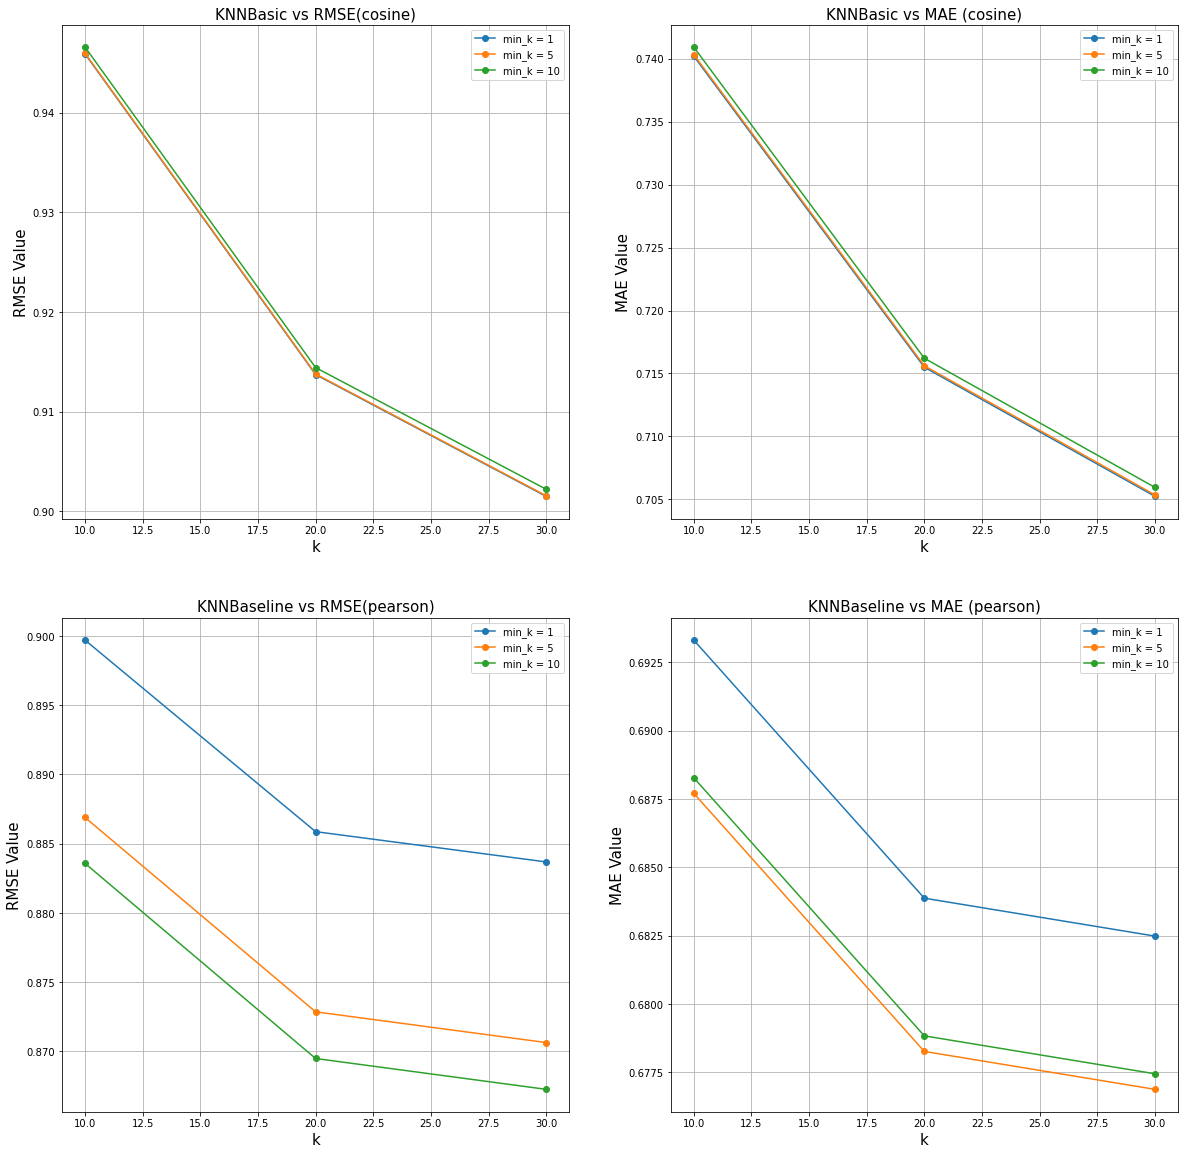

In [246]:
plt.figure(figsize=(20,20))

scale = len(min_k_list)
j = 1
for i in range(len(models_info)):
    model = models_info[i][1]
    rmse_idx_list, rmse_scoring = find_idx('rmse', model)
    mae_idx_list, mae_scoring = find_idx('mae', model)
    plt.subplot(len(models_info), 2, j)
    plt.title(models_info[i][0] + ' vs RMSE('+ rmse_scoring + ')', loc='center', fontsize=15)
    model_rmse = model.cv_results['mean_test_rmse'][rmse_idx_list]
    model_mae = model.cv_results['mean_test_mae'][mae_idx_list]
    for z in range(scale): 
        y = model_rmse[z::scale]
        plt.plot(k_list, y,  marker='o', label = 'min_k = ' + str(min_k_list[z]))
    plt.xlabel('k', fontsize=15)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel('RMSE Value', fontsize=15)
    plt.legend(fontsize=10, loc='best')
    plt.grid()

    plt.subplot(len(models_info), 2, j + 1)
    plt.title(models_info[i][0] + ' vs MAE ('+ mae_scoring + ')', loc='center', fontsize=15)
    for z in range(scale):   
        y = model_mae[z::scale]
        plt.plot(k_list, y,  marker='o', label = 'min_k = ' + str(min_k_list[z]))
    plt.xlabel('k', fontsize=15)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel('MAE Value', fontsize=15)
    plt.legend(fontsize=10, loc='best')
    plt.grid()
    j +=2


plt.show()

In [160]:
matrix_fact_dict = {'SVD' : SVD, 'SVD++' : SVDpp}

def grid_matrix_fact(model_dict, n_epochs=[10, 20, 30], lr_all=[0.01], cv=5):
    results_list = []
    #Define param grid
    param_grid = dict()
    param_grid['n_epochs'] = n_epochs
    param_grid['lr_all'] = lr_all
    for name, model in model_dict.items():
        grid = GridSearchCV(model,param_grid, cv=cv, n_jobs=-1)
        grid.fit(data)
        print(f' Best parameters for model {name} are {grid.best_params}')
        results_list.append((name, grid))
    return results_list

In [161]:
grid_matrix_fact(matrix_fact_dict)

 Best parameters for model SVD are {'rmse': {'n_epochs': 10, 'lr_all': 0.01}, 'mae': {'n_epochs': 10, 'lr_all': 0.01}}
 Best parameters for model SVD++ are {'rmse': {'n_epochs': 10, 'lr_all': 0.01}, 'mae': {'n_epochs': 10, 'lr_all': 0.01}}


[('SVD', <surprise.model_selection.search.GridSearchCV at 0x7f78933020d0>),
 ('SVD++', <surprise.model_selection.search.GridSearchCV at 0x7f7893302340>)]

In [170]:
models_info

[('KNNBasic item_based',
  <surprise.model_selection.search.GridSearchCV at 0x7f78893aa2e0>),
 ('KNNBaseline item_based',
  <surprise.model_selection.search.GridSearchCV at 0x7f7889b7d880>),
 ('KNNBasic item_based',
  <surprise.model_selection.search.GridSearchCV at 0x7f7892cda490>),
 ('KNNBaseline item_based',
  <surprise.model_selection.search.GridSearchCV at 0x7f78981aa3a0>)]

Comparison of algorithms.

In [145]:
rmse = []
mae = []
for name, grid in models_info:
    print(name)                                                                                                                                
    # now test on the trainset                                                 
    trainset = data.build_full_trainset()
    model = grid.best_estimator['rmse']
    model.fit(trainset)                                          

    # Compute unbiased accuracy on B
    testset = data.construct_testset(test_raw_ratings)  # testset is now the set B
    predictions = model.test(testset)
    print('Unbiased accuracy on B,', end=' ')
    accuracy.rmse(predictions)                                                                                        
    rmse_score = accuracy.rmse(predictions)
    mae_score = accuracy.mae(predictions)
    print("RMSE: {}".format(rmse_score))
    print("MAE: {}".format(mae_score))
    rmse.append(rmse_score)
    mae.append(mae_score)

KNNBasic item_based
Computing the cosine similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.7919
Unbiased accuracy on B, RMSE: 0.9106
RMSE: 0.9106
MAE:  0.7158
RMSE: 0.9106010022820918
MAE: 0.7158077109984019
KNNBaseline item_based
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.7450
Unbiased accuracy on B, RMSE: 0.8774
RMSE: 0.8774
MAE:  0.6863
RMSE: 0.8773933642828307
MAE: 0.6862780422147139


In [158]:
d = {'RMSE': rmse, 
     'MAE': mae
    }
df = pd.DataFrame(data=d)
#df.insert(loc=0, column='Method', value=['KNNBasic','KNNBaseline',
#              'KNNWithZScore','KNNWithMeans'])
df.insert(loc=0, column='Method', value=['KNNBasic','KNNBaseline'])
color = (df.RMSE == df.RMSE.min()).map({True: 'background-color: yellow', False: 'background_color: white'})
df.style.apply(lambda s: color)

,Method,RMSE,MAE
0,KNNBasic,0.910601,0.715808
1,KNNBaseline,0.877393,0.686278


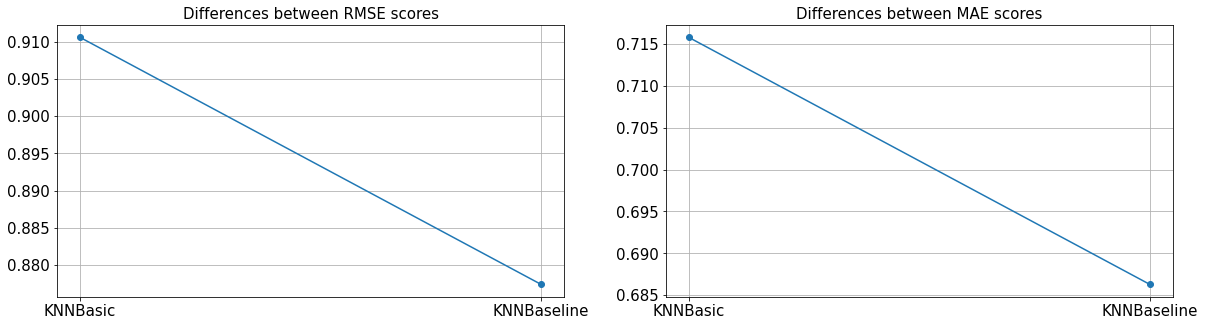

In [147]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_diff(df, 'Method', 'RMSE')
plt.subplot(1, 2, 2)
plot_diff(df, 'Method', 'MAE')
plt.show()

## Recommendations

Now we can finally recommend books for the users. 
Let's use the algorithm which has the lowest RMSE on test set.

In [23]:
model_idx = df['rmse'].idxmin()
model = results[model_idx][1]
model

Let's recommend 10 books for user 3173.

In [46]:
top_n = get_top_n(3173, ratings, model,n=10)
get_names(top_n, books)

,book_id,prediction,pred_rating,authors,title
0,7368,4.977298,5,C.S. Pacat,"Captive Prince: Volume Two (Captive Prince, #2)"
1,8634,4.903610,5,Ibraheem Abbas,حوجن [Ḥawjan]
2,3241,4.845167,5,Leigh Bardugo,"Crooked Kingdom (Six of Crows, #2)"
3,1788,4.813306,5,Bill Watterson,The Calvin and Hobbes Tenth Anniversary Book
4,2149,4.806308,5,George R.R. Martin,A Song of Ice and Fire (A Song of Ice and Fire...
5,862,4.803856,5,Brandon Sanderson,"Words of Radiance (The Stormlight Archive, #2)"
6,2767,4.800888,5,Brian K. Vaughan,"Saga, Vol. 3 (Saga, #3)"
7,5312,4.786217,5,Mike Mignola,"Hellboy, Vol. 3: The Chained Coffin and Others..."
8,4868,4.781562,5,James E. Talmage,Jesus the Christ
9,7910,4.776414,5,V.S. Ramachandran,Phantoms in the Brain: Probing the Mysteries o...


In [45]:
ratings.user_id

0              1
44             8
45             8
46             8
47             8
           ...  
5976347    41259
5976456     3173
5976458    53358
5976459    53358
5976471    50229
Name: user_id, Length: 895064, dtype: int64

Let's look at the list of books which user 3173 gave rate 5 and compare it to recommendation list

In [49]:
get_names(ratings[(ratings.rating == 5) & (ratings.user_id == 3173)], books)

,user_id,book_id,rating,authors,title
0,3173,250,5,R.J. Palacio,Wonder
1,3173,70,5,Orson Scott Card,"Ender's Game (Ender's Saga, #1)"
2,3173,4112,5,Donald J. Sobol,"Encyclopedia Brown, Boy Detective (Encyclopedi..."
3,3173,6,5,John Green,The Fault in Our Stars
4,3173,3630,5,Ron Rash,Serena
5,3173,7713,5,Hiroshi Sakurazaka,All You Need Is Kill
6,3173,164,5,Rainbow Rowell,Eleanor & Park
7,3173,591,5,Sherman Alexie,The Absolutely True Diary of a Part-Time Indian
8,3173,610,5,Daniel James Brown,The Boys in the Boat: Nine Americans and Their...
9,3173,285,5,Graeme Simsion,"The Rosie Project (Don Tillman, #1)"


#  References
1. https://towardsdatascience.com/how-does-collaborative-filtering-work-da56ea94e331
2. http://surprise.readthedocs.io/en/stable/getting_started.html
3. https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1